<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Workshop SWDB 2024 </h1> 
<h3 align="center">Day 3 2024 - Neuron Morphology</h3> 
<h3 align="center">Supplemental Notebook: Extracting morphological features</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<p>Analyzing neuron morphology data begins with accessing it--and understanding how the data is structured. This notebook reviews an example of how to load, examine, and visualize a neuron skeleton in both 2D and 3D. 
    
<p> Then, we will introduce some tools for accessing different features within the skeleton data. This is also a reference notebook you may come back to for specific tools to answer the scientific questions. 
    
<p>We will quantify the:    
<ul>
<li> path-length of axons and dendrites
<li> distribution of branch lengths
<li> relationship between axon and dendrite, re: branch number and path-length.
</ul>
    
    
</div>

In [1]:
#all imports
import pandas as pd
import numpy as np
from os.path import join as pjoin
import cloudvolume
from meshparty import skeleton
import skeleton_plot as skelplot

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("..") # to access utils folder

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
 
<h2> Load a precomputed skeleton </h2>

<p> Previously we viewed the Electron Microscopy (EM) and Light Microscopy (LM) reconstructions seperately. However, both datasets exist as part of the common coordinate framework (CFF). 

<p> You can see both example cells rendered in CCF in <a ref="https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/4754960374824960">Neuroglancer</a>.
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:</b>  Choose your own adventure: use either the EM or LM data path from the previous notebook. Return here later to select the other data type.
    
<p>Note: we use a convenient utility function here to load the precomputed skeleton and format it as a meshwork skeleton. This is the same operation as in Day 1's <i>Notebook 0</i> .
</div>

In [3]:
#Answer 1
from utils.skeleton_loading_utils import load_em_skeleton_as_meshwork

skeleton_id = 864691135591041291
sk, conversion_factor = load_em_skeleton_as_meshwork(skeleton_id)

In [4]:
#Answer 2 
from utils.skeleton_loading_utils import load_lm_skeleton_as_meshwork

skeleton_id = 14
sk, conversion_factor = load_lm_skeleton_as_meshwork(skeleton_id)

(5435325.5, 14014771.0, 7384447.5, 2283567.75)

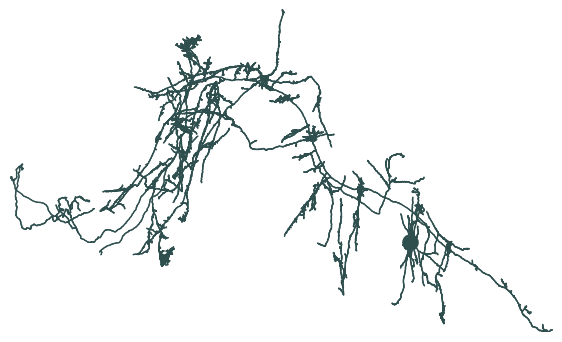

In [5]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    line_width = 1,
    plot_soma = True,
    invert_y = True,
    x="x",
    y="y",
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2> Calculate Basic Morphology features of the skeleton </h2>

<p> We will be using the <a href="https://github.com/CAVEconnectome/MeshParty/">MeshParty</a> toolbox which simplifies the process of extracting features like branches and endpoints, and calculating <b>path-lengths</b>--the distance in space traversed by the neurites.
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3>----- Section 1.1: Vertices and Neighborhoods ----- </h3>

In [6]:
#TODO: INCLUDE FIGURE TO EASILY EXPLAIN WHAT THESE FEATURES ARE

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Vertices </h4>
    
<p> Each vertex is represented by an integer and has an xyz coordinate associated to it. The neighborhood of a node includes all nodes that are directly connected to it by a single edge. Here is an example were we sample a random node and list its neighbors. 
</div>

In [7]:
# Vertices
print(f"There are {len(sk.vertices)} vertices in this neuron")

There are 30116 vertices in this neuron


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Branch Points </h4>

<p> Vertices with three or more neighbors
    
</div>

In [8]:
# Branch points
print("Branch points are at the following vertices: \n",sk.branch_points)

Branch points are at the following vertices: 
 [    0     1     3 ... 30092 30094 30109]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> End points </h4>
    
<p> Vertices with exactly one neighbor.
    
</div>

In [9]:
# End points
print("End points are at the following vertices: \n",sk.end_points)

End points are at the following vertices: 
 [   72   131   186 ... 30102 30111 30115]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Root </h4>
    
<p> Unique vertex that represents the soma. In the directed graph, a node with no parents. 
</div>

In [10]:
# Root - the point associated with the root node, which is the soma
print("Root is vertex: ", sk.root.item())

Root is vertex:  0


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.1.1:</b>  Find the branch point with the most neighbors
    
<p><b>Exercise 1.1.2:</b>  Print out the degree distribution of the neuron (i.e. the fraction of nodes with 1, 2, ..., k neighbors)
    
<p><b>Exercise 1.1.3:</b>  Based on the results of the previous exercise, explain why the topology of a neuron is nearly a cayley tree
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3>----- Section 1.2: Paths and Segments ----- </h3>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Segments</h4>
    
<p>The path of nodes between two vertices i and j which are assumed to be a root, branch point, or endpoint.
    
</div>

In [11]:
# Segments - the branch segments
print("The number of branch segments are: \n",len(sk.segments))

The number of branch segments are: 
 6197


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Path between </h4>
    
<p> The skeleton meshwork's <code>path_between()</code> function finds the <b>vertices on the path</b> between two points on the skeleton graph.
    
</div>

In [12]:
# Path-length for all neurites
nodes_between = sk.path_between(0,150) 
print("Path between the given nodes: ", nodes_between)

Path between the given nodes:  [  0   1   2   3 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Calculate pathlength </h4>
    
<p> The skeleton meshwork's <code>path_length()</code> function calculates the <b>physical</b> distance along the path for a neuron
    
</div>

In [13]:
# Path-length for all neurites
full_pathlength = sk.path_length() / conversion_factor # Convert to nanometers
print("Path-length of the entire neuron: ", full_pathlength, ' um')

Path-length of the entire neuron:  220629728.0  um


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Use the pathlength operation on subsets of the path as well
    
</div>

In [14]:
# Path-length for arbitrary segment
example_segment = 11
segment_pathlength = sk.path_length(sk.segments[example_segment]) / conversion_factor # Convert to nanometers 
print("Path-length of one segment: ", segment_pathlength, ' um')

Path-length of one segment:  113196.3671875  um


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.2.1:</b> Find the endpoint with the longest sequence of segments that connects it to the root
    
<p><b>Exercise 1.2.2:</b> Print out the distribution of hop distances between endpoints and the soma (i.e. the fraction of endpoints that are 1, 2, ..., k hops from the soma)
    
<p><b>Exercise 1.2.3:</b> Compute the cumulative distribution of distance-from-soma for branching points (i.e. given a distance d > 0, what fraction of branching points have a path length of at most d microns from the soma.). Are there any distances that you see lots of branching?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3>----- Section 1.3: Subgraphs ----- </h3>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Visualize path of one segment </h4
    
<p> Combining the skeleton plot functionality shown previously, here we overlay an example segment. </p>
    
</div>

(5435325.5, 14014771.0, 7384447.5, 2283567.75)

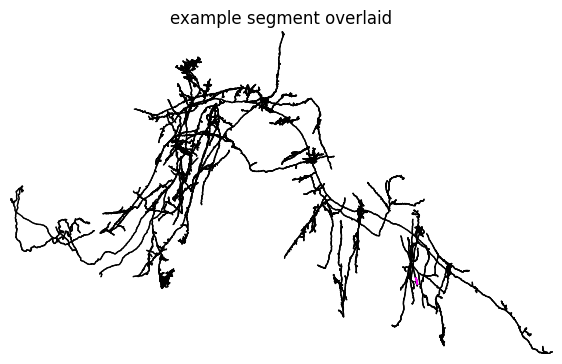

In [15]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title="example segment overlaid",
    line_width=1,
    invert_y=True,
    color='k',
    x="x",
    y="y",
)

# index into the skeleton vertices with the segment
ax.plot(sk.vertices[sk.segments[example_segment]][:,0], 
        sk.vertices[sk.segments[example_segment]][:,1], 
        color='magenta')

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Using Masks to Select Parts of the Skeleton </h4>
    
<p> One of the most useful features of the skeleton meshwork's is the ability to <b>mask</b> or select only parts of the skeleton to work with at a time. The function <code>apply_mask()</code> acts on the meshwork skeleton, and will apply in place if <code>apply_mask(in_place=True)</code>. 

<p>
    
<p> <b><i>Warning</i></b>: be aware when setting a mask in place--mask operations are additive. To reset the mask completely, use <code>reset_mask(in_place=True)</code>.
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Let's select a set of nodes from example segment 11:
    
</div>

In [16]:
example_segment = 11
selected_nodes = sk.segments[example_segment]
print(selected_nodes)

[245 244 243 242 241 240 239 238 237 236 235 234 233 232 231 230 229]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Apply a mask to these nodes:
    
</div>

In [17]:
#reset to make sure you have the full skeleton
sk.reset_mask(in_place=True)
# Apply mask
sk_masked = sk.apply_mask(selected_nodes)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Check that this masked skeleton matches the pathlength calculated above
    
</div>

In [18]:
sk_masked.path_length() / conversion_factor

113196.359375

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Selecting Axons and Dendrites </h4>
    
<p> Critically, <code>apply_mask()</code> allows us to mask a neuron according to its compartment label: axon, dendrite, soma, etc. 
    
<p> <b>Compartment label conventions</b> (from standardized swc files <a href="www.neuromorpho.org">www.neuromorpho.org</a>
<ul>
<li> 0 - undefined
<li> 1 - soma
<li> 2 - axon
<li> 3 - (basal) dendrite
<li> 4 - apical dendrite
<li> 5+ - custom
</ul>
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p>Create a skeleton only with the dendrites and compute its path length
    
</div>

In [19]:
sk.vertex_properties['compartment']

array([1., 3., 3., ..., 2., 2., 2.], dtype=float32)

In [20]:
# Select the indices associated with the axon, and dendrites

dendrite_inds = (sk.vertex_properties['compartment']==3) | (sk.vertex_properties['compartment']==4)| (sk.vertex_properties['compartment']==1) #soma is included here to connect the dendrite graphs 

# create new skeleton that masks (selects) only the axon
sk_dendrite = sk.apply_mask(dendrite_inds)
print("Dendrite pathlength of all branches is : ", sk_dendrite.path_length() / conversion_factor, ' um')

Dendrite pathlength of all branches is :  12003578.0  um


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.3.1:</b>  Create an axon skeleton and compute its path length
</div>

In [21]:
#Answer
axon_inds = sk.vertex_properties['compartment']==2
sk_axon = sk.apply_mask(axon_inds)
print("Axon pathlength is : ", sk_axon.path_length() / conversion_factor, ' um')


Axon pathlength is :  208600848.0  um


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Selecting Dendrite Segments </h4>
    
<p> Let's look at all the segments in the dendrite graph:
    
</div>

(11437349.65, 12358849.35, 7040487.525, 5167780.975)

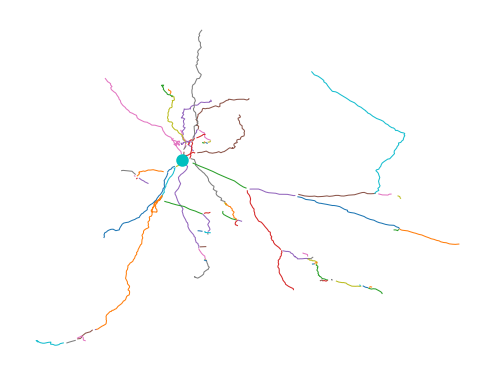

In [22]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)

for ss in range(len(sk_dendrite.segments)):
    seg = sk_dendrite.segments[ss]

    ax.plot(sk_dendrite.vertices[seg][:,0], 
            sk_dendrite.vertices[seg][:,1], linewidth=0.5)

# add soma marker
ax.plot(sk.vertices[sk.root][0], 
        sk.vertices[sk.root][1], 'oc', markersize=5)
    
ax.invert_yaxis()
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Selecting Downstream points</h4>
    
<p> Meshwork has a nifty function for subselecting points: downstream points. For a given point, downstream points are defined as points on paths from endpoints to the root which are further than the given point. For example, if the skeleton path is : A-B-C-D-E where A is the root, D and E are downstream points of C. With branching, this can be more complex. To find the downstream points from say the 30th branch point, we can do:
    
</div>

In [23]:
# Select downstream nodes from one branch point
downstream_nodes = sk.downstream_nodes(sk.branch_points[3])

(5435325.5, 14014771.0, 7384447.5, 2283567.75)

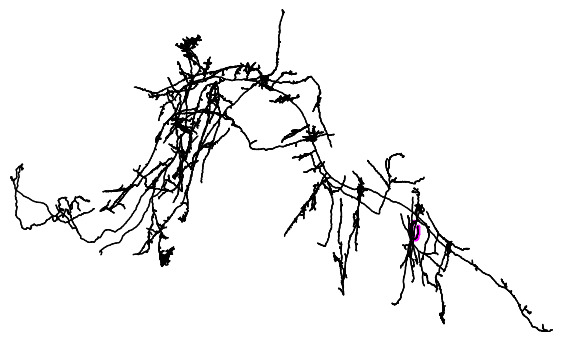

In [24]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    line_width = 1,
    color='k',
    invert_y = True,
    x="x",
    y="y",
)

# Add the downstream vertices as red points (Note: this works for x-y plot orientation; select the columns appropriate to your skeleton orientation)
ax.scatter(sk.vertices[downstream_nodes][:,0], sk.vertices[downstream_nodes][:,1], c='magenta', s=2)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3>----- Section 1..4: Analyzing the Morphology of a Single Neuron ----- </h3>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
    
<h4> Distribution of branch lengths </h4>
    
    
<p> Note that each have different lengths. Let's create a histogram of all the path lengths of the segments/branches in dendrite graph
    
</div>

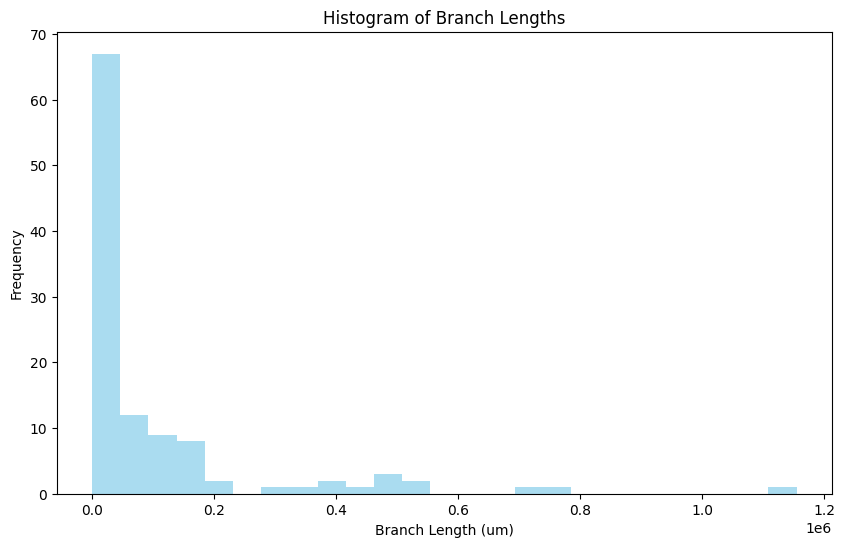

In [25]:
# find Branch lengths
branch_lengths = np.array([sk_dendrite.path_length(seg) for seg in sk_dendrite.segments]) / conversion_factor
plt.figure(figsize=(10, 6))
plt.hist(branch_lengths, bins='auto', color='skyblue', alpha=0.7)
plt.title("Histogram of Branch Lengths")
plt.xlabel("Branch Length (um)")
plt.ylabel("Frequency")
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
    
<h4> Compute longest path </h4>
    
    
<p> What is the maximum distance you could travel from tip to tip without repeating a node?
    
</div>

In [32]:
# First, find the path length for every tip (end point) to root:
end_point_df = pd.DataFrame({'end_point': sk.end_points, 
                             'dist_to_root': sk.distance_to_root[sk.end_points]})
end_point_df = end_point_df.sort_values('dist_to_root', ascending=False).reset_index(drop=True)

furthest_ind = end_point_df.iloc[0].end_point.astype(int)

# Now find the next longest point that is not on the same path
path_to_furthest = sk.path_between(furthest_ind, sk.root)

path_overlap_list = []
for ii in end_point_df.index:
    ii_path = sk.path_between(end_point_df.iloc[ii].end_point, sk.root)
    path_overlap = len(np.intersect1d(path_to_furthest, ii_path))
    path_overlap_list.append(path_overlap)
    
end_point_df['path_overlap'] =    path_overlap_list
second_furthest_ind = end_point_df.iloc[np.argmin(end_point_df.path_overlap)].end_point.astype(int)

# calculate the path between:
longest_path_indices = sk.path_between(furthest_ind, second_furthest_ind)
print("Longest pathlength between two points is : ",
      sk.path_length(longest_path_indices) / conversion_factor,
      ' um')

Longest pathlength between two points is :  4829603.0  um


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
    
<h4> Plot the longest path </h4>
    
    
<p> Tip: try changing the orientation from XZ to XY or YZ
    
</div>

(11073979.0, 13545874.0, 5709712.5, 4554698.0)

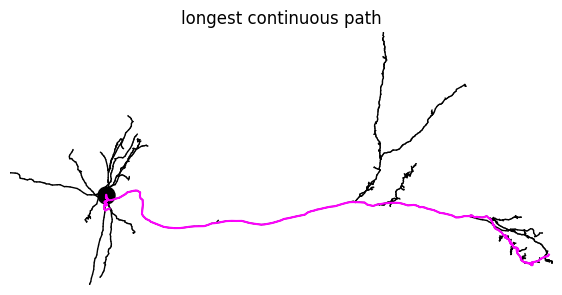

In [37]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title="longest continuous path",
    line_width=1,
    plot_soma=True,
    soma_size = 150,
    pull_radius=True,
    invert_y=True,
    pull_compartment_colors=False,
    color='black',
    x="x",
    y="z",
)

# index into the skeleton vertices with the segment indices
ax.plot(sk.vertices[longest_path_indices][:,0], 
        sk.vertices[longest_path_indices][:,2], 
        color='magenta')

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3>----- Section 1.5: AComparing the Morphology of Multiple Neurons ----- </h3>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Plot the relationship of axon and dendrite pathlength </h4>
    
<p> Here we try to plot axon length vs dendrite length by selecting a random set. However, this set can be chosen based on some manual or automatic criterion for analysis. 
    
</div>

In [28]:
''' read 10 neurons '''
# #For EM:
# Ids = [864691134884807418, 864691134886016762, 864691134886037498, 864691134918642954,
#        864691134941063523, 864691134941217635, 864691134941291363, 864691134941297763,
#        864691134941299811, 864691134948652540]

#For LM 
Ids = [1,2,3,4,5,7,9,14,16,17]

In [29]:
'''do a scatter of axon length to dendrite length'''
ax = []
de = []

for skeleton_id in Ids:
    # # For EM read precomputed
    # sk, _ = load_em_skeleton_as_meshwork(skeleton_id)
    
    # For LM
    sk, _ = load_lm_skeleton_as_meshwork(skeleton_id)
    
    #select axon
    axon_inds = sk.vertex_properties['compartment']==2
    sk_axon = sk.apply_mask(axon_inds)
    
    #calculate, append pathlength
    ax.append(sk_axon.path_length()/conversion_factor)
    
    #select dendrite
    dendrite_inds = (sk.vertex_properties['compartment']==3) | (sk.vertex_properties['compartment']==4)| (sk.vertex_properties['compartment']==1) #soma is included here to connect the dendrite graphs 
    sk_dendrite = sk.apply_mask(dendrite_inds)
    
    #calculate, append pathlength
    de.append(sk_dendrite.path_length()/conversion_factor)    


<Axes: xlabel='dendrite length', ylabel='axon length'>

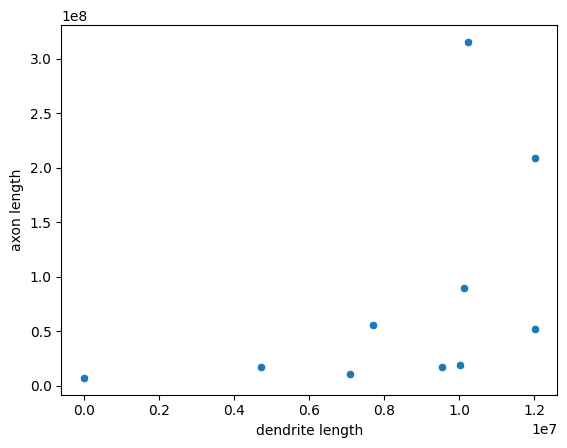

In [30]:
#plot axon vs dendrite lengths
d = {'axon length': ax, 'dendrite length': de}
dataframe = pd.DataFrame(data=d)
sns.scatterplot(data = dataframe, y ="axon length", x= "dendrite length")